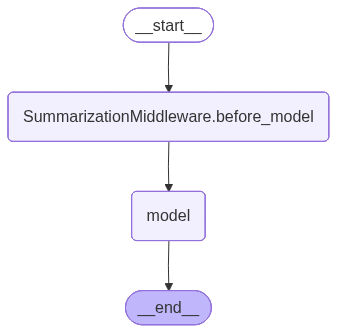

In [25]:
from langchain.agents import create_agent
from langchain.agents.middleware import SummarizationMiddleware
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import InMemorySaver
from dotenv import load_dotenv
from langchain.messages import HumanMessage

import os
load_dotenv()
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')

llm = ChatGroq(
    model="qwen/qwen3-32b",
    temperature=0,
    max_tokens=None,
    reasoning_format="parsed",
    timeout=None,
    max_retries=2,
    # other params...
)

config = {'configurable':{'thread_id':'test'}}

agent = create_agent(
    model = llm,
    checkpointer=InMemorySaver(),
    middleware=[SummarizationMiddleware(
        model=llm,
        trigger=('messages',10),
        keep=("messages", 4),
    )]
)

agent


In [26]:
questions =[
    "What is the capital of France?",
    "What is the largest planet in the solar system?",
    "What is the chemical symbol for gold?",
    "What is the capital of Peru?",
    "What is the chemical symbol for gold?",
    "What is the chemical symbol for silver?",
]

In [27]:
for q in questions:
    response = agent.invoke({"messages":[HumanMessage(content=q)]},config=config)
    print(len(response["messages"]))
    print(response["messages"][-1])

2
content='The capital of France is **Paris**. Known as the "City of Light," Paris is renowned for its cultural landmarks such as the Eiffel Tower, the Louvre Museum, and Notre-Dame Cathedral. It serves as the political, economic, and cultural center of France. \n\n**Answer:** Paris.' additional_kwargs={'reasoning_content': 'Okay, so the user is asking, "What is the capital of France?" Hmm, I need to make sure I get this right. Let me think. I remember from school that France is a country in Europe, and its capital is a major city. Wait, Paris? Yeah, I think that\'s it. But wait, maybe I should double-check. Sometimes countries have different capitals, like how some people might confuse Paris with another city. Let me recall... France\'s capital is definitely Paris. I\'ve heard of Paris being called the City of Light, and it\'s known for the Eiffel Tower and the Louvre. Yeah, that\'s Paris. I don\'t think there\'s any other city that\'s the capital. Maybe some people might think Lyon o

In [28]:
#also we can use token,fraction to summarize conversation

In [29]:
## Human in the loop middleware

In [30]:
from langchain.agents.middleware import HumanInTheLoopMiddleware
from langchain.tools import tool


In [31]:
@tool
def send_email(to: str, subject: str, body: str) -> str:
    """Send an email to the specified recipient with the specified subject and body."""
    return f"Email sent to {to} with subject {subject} and body {body}"

@tool
def read_email(to: str) -> str:
    """Read an email from the specified recipient."""
    return f"Email read from {to}"

email_tool = [send_email, read_email]


In [32]:
help(HumanInTheLoopMiddleware)

Help on class HumanInTheLoopMiddleware in module langchain.agents.middleware.human_in_the_loop:

class HumanInTheLoopMiddleware(langchain.agents.middleware.types.AgentMiddleware)
 |  HumanInTheLoopMiddleware(
 |      interrupt_on: dict[str, bool | InterruptOnConfig],
 |      *,
 |      description_prefix: str = 'Tool execution requires approval'
 |  ) -> None
 |
 |  Human in the loop middleware.
 |
 |  Method resolution order:
 |      HumanInTheLoopMiddleware
 |      langchain.agents.middleware.types.AgentMiddleware
 |      typing.Generic
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(
 |      self,
 |      interrupt_on: dict[str, bool | InterruptOnConfig],
 |      *,
 |      description_prefix: str = 'Tool execution requires approval'
 |  ) -> None
 |      Initialize the human in the loop middleware.
 |
 |      Args:
 |          interrupt_on: Mapping of tool name to allowed actions.
 |
 |              If a tool doesn't have an entry, it's auto-approved by default

In [33]:
agent_email = create_agent(
    model = llm,
    tools = email_tool,
    checkpointer = InMemorySaver(),
    middleware=[
        HumanInTheLoopMiddleware(
            interrupt_on={
                "send_email": {
                    "allowed_decisions": ["approve", "edit", "reject"],
                },
                "read_email": False,
            }
        )
    ]
)

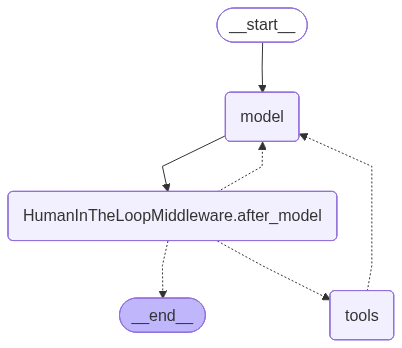

In [34]:
agent_email

In [35]:
result = agent_email.invoke({'messages':[HumanMessage(content="send email with hello my friend with subject hello my friend to hary@gmail.com")]},config=config)
print(result)

{'messages': [HumanMessage(content='send email with hello my friend with subject hello my friend to hary@gmail.com', additional_kwargs={}, response_metadata={}, id='c53d3ad8-bdc9-4527-93b2-b8a8e41bd28c'), AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user wants to send an email. Let me see. The message is "hello my friend" with the subject "hello my friend" to hary@gmail.com. I need to use the send_email function. Let me check the parameters. The required fields are to, subject, and body. The user provided all three: to is hary@gmail.com, subject is "hello my friend", and the body is the same. So I should structure the tool call with these parameters. Make sure the JSON is correctly formatted with the right keys. No need for any other functions here since it\'s a send request. Alright, that should do it.\n', 'tool_calls': [{'id': '5zyypgx7t', 'function': {'arguments': '{"body":"hello my friend","subject":"hello my friend","to":"hary@gmail.com"}', 'name': 'sen

In [37]:
from langgraph.types import Command

response = agent_email.invoke(
    Command( 
        resume={"decisions": [{"type": "approve"}]}  # or "reject"
    ), 
    config=config # Same thread ID to resume the paused conversation
)
print(response['messages'][-1])

content='The email has been successfully sent to hary@gmail.com with the subject and body "hello my friend". Let me know if you need anything else!' additional_kwargs={'reasoning_content': 'Okay, the user asked to send an email with the subject and body "hello my friend" to hary@gmail.com. I used the send_email function with those parameters. The tool response confirmed the email was sent. Now, I should let the user know it\'s done successfully. Keep the response simple and confirm the action.\n'} response_metadata={'token_usage': {'completion_tokens': 101, 'prompt_tokens': 319, 'total_tokens': 420, 'completion_time': 0.171384069, 'completion_tokens_details': {'reasoning_tokens': 66}, 'prompt_time': 0.013081715, 'prompt_tokens_details': None, 'queue_time': 0.050825985, 'total_time': 0.184465784}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'} id='lc_run--019bb8a2-37